## Notebook: Image Recognition - Gender, Smile, Age (Young/Old) Detection
---

## Dataset
(https://www.kaggle.com/jessicali9530/celeba-dataset): 

### Context

202,599 number of face images of various celebrities
10,177 unique identities, but names of identities are not given
40 binary attribute annotations per image
5 landmark locations


### Import libraries

In [198]:
import pandas as pd
import numpy as np
import cv2    
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import f1_score

from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras import optimizers
from keras.models import Sequential, Model 
from keras.layers import Dropout, Flatten, Dense
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.utils import np_utils
from keras.optimizers import SGD
from keras import regularizers
from keras.layers import Conv2D, Flatten, MaxPooling1D, BatchNormalization
from keras.layers import GlobalAveragePooling2D
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from IPython.core.display import display, HTML
from PIL import Image
from io import BytesIO
import os
import base64
from keras.applications.xception import Xception
plt.style.use('ggplot')

%matplotlib inline

In [2]:
import tensorflow as tf
print(tf.__version__)

2.1.0


## Data Exploration

We will be using the CelebA Dataset, which includes images of 178 x 218 px. Below is an example of how the pictures looks like.

In [242]:
# set variables 
main_folder = ''
images_folder = main_folder + 'img_align_celeba/img_align_celeba/'

EXAMPLE_PIC = images_folder + '000001.jpg'

TRAINING_SAMPLES = 5000
VALIDATION_SAMPLES = 2000
TEST_SAMPLES = 500
IMG_WIDTH = 178
IMG_HEIGHT = 218

In [243]:
# import the data set that include the attribute for each picture
df_attr = pd.read_csv(main_folder + 'list_attr_celeba.csv')
df_attr.set_index('image_id', inplace=True)
df_attr.replace(to_replace=-1, value=0, inplace=True) #replace -1 by 0
df_attr.shape

(202599, 40)

In [174]:
# List of available attributes
for i, j in enumerate(df_attr.columns):
    print(i, j)

0 5_o_Clock_Shadow
1 Arched_Eyebrows
2 Attractive
3 Bags_Under_Eyes
4 Bald
5 Bangs
6 Big_Lips
7 Big_Nose
8 Black_Hair
9 Blond_Hair
10 Blurry
11 Brown_Hair
12 Bushy_Eyebrows
13 Chubby
14 Double_Chin
15 Eyeglasses
16 Goatee
17 Gray_Hair
18 Heavy_Makeup
19 High_Cheekbones
20 Male
21 Mouth_Slightly_Open
22 Mustache
23 Narrow_Eyes
24 No_Beard
25 Oval_Face
26 Pale_Skin
27 Pointy_Nose
28 Receding_Hairline
29 Rosy_Cheeks
30 Sideburns
31 Smiling
32 Straight_Hair
33 Wavy_Hair
34 Wearing_Earrings
35 Wearing_Hat
36 Wearing_Lipstick
37 Wearing_Necklace
38 Wearing_Necktie
39 Young


Smiling    1
Male       0
Young      1
Name: 000001.jpg, dtype: int64

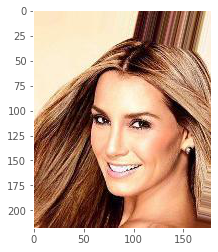

In [175]:
# plot picture and attributes
img = load_img(EXAMPLE_PIC)
plt.grid(False)
plt.imshow(img)
df_attr.loc[EXAMPLE_PIC.split('/')[-1]][['Smiling','Male','Young']] #some attributes

## Training, Validation and Test

The recommended partitioning of images into training, validation, testing of the data set is: 
* 1-162770 are training
* 162771-182637 are validation
* 182638-202599 are testing

The partition is in file <b>list_eval_partition.csv</b>

Due time execution, by now we will be using a reduced number of images:

* Training 5000 images
* Validation 2000 images
* Test 500 Images


In [177]:
df_partition = pd.read_csv(main_folder + 'list_eval_partition.csv')
df_partition.head()

,image_id,partition
0,000001.jpg,0
1,000002.jpg,0
2,000003.jpg,0
3,000004.jpg,0
4,000005.jpg,0


In [178]:
df_partition['partition'].value_counts().sort_index()

0    162770
1     19867
2     19962
Name: partition, dtype: int64

#### Join the partition and the attributes in the same data frame

In [179]:
# join the partition with the attributes
df_partition.set_index('image_id', inplace=True)
df_par_attr = df_partition.join(df_attr['Male'], how='inner')
df_par_attr = df_par_attr.join(df_attr['Smiling'], how='inner')
df_par_attr = df_par_attr.join(df_attr['Young'], how='inner')
df_par_attr.head()

,partition,Male,Smiling,Young
image_id,,,,
000001.jpg,0,0,1,1
000002.jpg,0,0,1,1
000003.jpg,0,1,0,1
000004.jpg,0,0,0,1
000005.jpg,0,0,0,1


In [180]:
def load_reshape_img(fname):
    img = load_img(fname)
    x = img_to_array(img)/255.
    x = x.reshape((1,) + x.shape)

    return x


def generate_df(partition, attr, num_samples):
    
    df_ = df_par_attr[(df_par_attr['partition'] == partition) 
                           & (df_par_attr[attr] == 0)].sample(int(num_samples/2))
    df_ = pd.concat([df_,
                      df_par_attr[(df_par_attr['partition'] == partition) 
                                  & (df_par_attr[attr] == 1)].sample(int(num_samples/2))])


    if partition != 2:
        x_ = np.array([load_reshape_img(images_folder + fname) for fname in df_.index])
        x_ = x_.reshape(x_.shape[0], 218, 178, 3)
        y_ = np_utils.to_categorical(df_[attr],2)

    else:
        x_ = []
        y_ = []

        for index, target in df_.iterrows():
            im = cv2.imread(images_folder + index)
            im = cv2.resize(cv2.cvtColor(im, cv2.COLOR_BGR2RGB), (IMG_WIDTH, IMG_HEIGHT)).astype(np.float32) / 255.0
            im = np.expand_dims(im, axis =0)
            x_.append(im)
            y_.append(target[attr])

    return x_, y_

### Data Augmentation

This is how an image will look like after data augmentation (based in the giving parameters below).

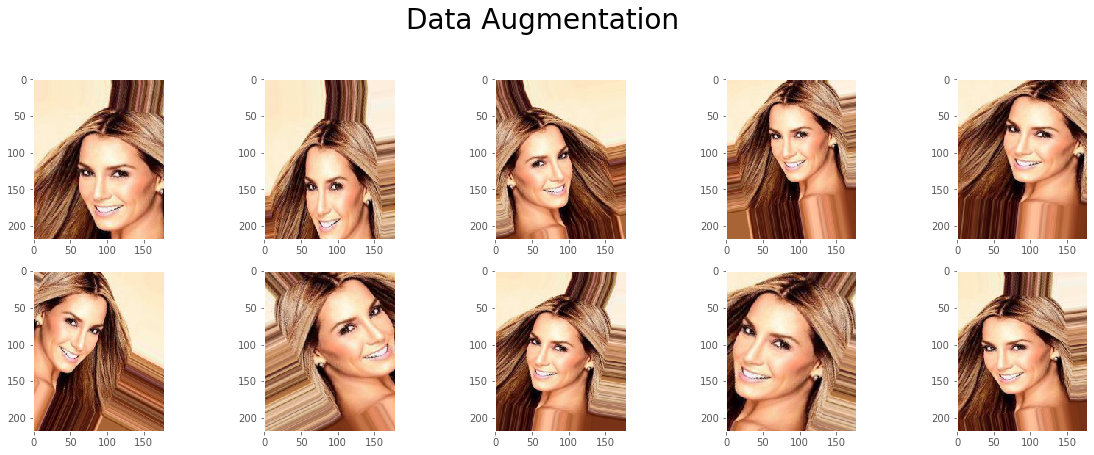

In [23]:
# Generate image generator for data augmentation
datagen =  ImageDataGenerator(
  #preprocessing_function=preprocess_input,
  rotation_range=30,
  width_shift_range=0.2,
  height_shift_range=0.2,
  shear_range=0.2,
  zoom_range=0.2,
  horizontal_flip=True
)

# load one image and reshape
img = load_img(EXAMPLE_PIC)
x = img_to_array(img)/255.
x = x.reshape((1,) + x.shape)

# plot 10 augmented images of the loaded iamge
plt.figure(figsize=(20,10))
plt.suptitle('Data Augmentation', fontsize=28)

i = 0
for batch in datagen.flow(x, batch_size=1):
    plt.subplot(3, 5, i+1)
    plt.grid(False)
    plt.imshow( batch.reshape(218, 178, 3))
    
    if i == 9:
        break
    i += 1
    
plt.show()

The result is a new set of images with modifications from the original one, that allows to the model to learn from these variations in order to take this kind of images during the learning process and predict better never seen images.

## Step 4: Build the Model

### 4.1. Set the Model

In [218]:
x_train, y_train = generate_df(0, 'Male', TRAINING_SAMPLES)
x_valid, y_valid = generate_df(1, 'Male', VALIDATION_SAMPLES)

train_datagen =  ImageDataGenerator(
  preprocessing_function=preprocess_input,
  rotation_range=30,
  width_shift_range=0.2,
  height_shift_range=0.2,
  shear_range=0.2,
  zoom_range=0.2,
  horizontal_flip=True,
)

train_generator = train_datagen.flow(
x_train, y_train,
batch_size=BATCH_SIZE,
)

valid_generator = train_datagen.flow(
x_valid, y_valid,
batch_size=BATCH_SIZE,
)


epochs = 20
learning_rate = 0.0001
batch_size = 32
weights = os.path.join('', 'weights.h5')
callbacks = [ EarlyStopping(monitor='val_loss', patience=5, verbose=0), 
              ModelCheckpoint(weights, monitor='val_loss', save_best_only=True, verbose=0),
              ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, verbose=0, mode='auto', min_delta=0.0001, cooldown=0, min_lr=0)]

base_model = Xception(input_shape=(IMG_HEIGHT, IMG_WIDTH, 3), include_top=False) # Average pooling reduces output dimensions
x = base_model.output
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(2, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)
model.compile(loss='categorical_crossentropy', optimizer=optimizers.Adam(lr=learning_rate), metrics=['accuracy'])

# ------ TRAINING ------
model.fit_generator(train_generator,steps_per_epoch=len(x_train)/batch_size,validation_data=valid_generator
                    ,callbacks=callbacks,epochs=epochs,verbose=1)

Epoch 1/20
157/156 [==============================] - 708s 5s/step - loss: 0.3352 - accuracy: 0.8662 - val_loss: 0.7019 - val_accuracy: 0.4625
Epoch 2/20
157/156 [==============================] - 741s 5s/step - loss: 0.1871 - accuracy: 0.9361 - val_loss: 0.7534 - val_accuracy: 0.8250
Epoch 3/20
157/156 [==============================] - 697s 4s/step - loss: 0.1518 - accuracy: 0.9485 - val_loss: 0.8002 - val_accuracy: 0.5860
Epoch 4/20
157/156 [==============================] - 732s 5s/step - loss: 0.1274 - accuracy: 0.9574 - val_loss: 0.0940 - val_accuracy: 0.9415
Epoch 5/20
157/156 [==============================] - 765s 5s/step - loss: 0.0973 - accuracy: 0.9637 - val_loss: 0.0155 - val_accuracy: 0.9655
Epoch 6/20
157/156 [==============================] - 699s 4s/step - loss: 0.1081 - accuracy: 0.9626 - val_loss: 0.0232 - val_accuracy: 0.9700
Epoch 7/20
157/156 [==============================] - 755s 5s/step - loss: 0.0889 - accuracy: 0.9678 - val_loss: 0.0386 - val_accuracy: 0.9645

In [219]:
x_train, y_train = generate_df(0, 'Smiling', TRAINING_SAMPLES)
x_valid, y_valid = generate_df(1, 'Smiling', VALIDATION_SAMPLES)

train_datagen =  ImageDataGenerator(
  preprocessing_function=preprocess_input,
  rotation_range=30,
  width_shift_range=0.2,
  height_shift_range=0.2,
  shear_range=0.2,
  zoom_range=0.2,
  horizontal_flip=True,
)

train_generator = train_datagen.flow(
x_train, y_train,
batch_size=BATCH_SIZE,
)

valid_generator = train_datagen.flow(
x_valid, y_valid,
batch_size=BATCH_SIZE,
)



epochs = 20
learning_rate = 0.0001
batch_size = 32
weights = os.path.join('', 'weights.h5')
callbacks = [ EarlyStopping(monitor='val_loss', patience=5, verbose=0), 
              ModelCheckpoint(weights, monitor='val_loss', save_best_only=True, verbose=0),
              ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, verbose=0, mode='auto', min_delta=0.0001, cooldown=0, min_lr=0)]

base_model = Xception(input_shape=(IMG_HEIGHT, IMG_WIDTH, 3), include_top=False) # Average pooling reduces output dimensions
x = base_model.output
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(2, activation='softmax')(x)
model_smile = Model(inputs=base_model.input, outputs=predictions)    
model_smile.compile(loss='categorical_crossentropy', optimizer=optimizers.Adam(lr=learning_rate), metrics=['accuracy'])

# ------ TRAINING ------
model_smile.fit_generator(train_generator,steps_per_epoch=len(x_train)/batch_size,validation_data=valid_generator
                    ,callbacks=callbacks,epochs=epochs,verbose=1)

Epoch 1/20
157/156 [==============================] - 713s 5s/step - loss: 0.6745 - accuracy: 0.6653 - val_loss: 0.6931 - val_accuracy: 0.5015
Epoch 2/20
157/156 [==============================] - 688s 4s/step - loss: 0.3636 - accuracy: 0.8523 - val_loss: 0.6389 - val_accuracy: 0.5000
Epoch 3/20
157/156 [==============================] - 682s 4s/step - loss: 0.2739 - accuracy: 0.8962 - val_loss: 0.2690 - val_accuracy: 0.8420
Epoch 4/20
157/156 [==============================] - 681s 4s/step - loss: 0.2777 - accuracy: 0.8885 - val_loss: 0.4513 - val_accuracy: 0.8645
Epoch 5/20
157/156 [==============================] - 683s 4s/step - loss: 0.2332 - accuracy: 0.9013 - val_loss: 0.1992 - val_accuracy: 0.8880
Epoch 6/20
157/156 [==============================] - 682s 4s/step - loss: 0.2390 - accuracy: 0.9117 - val_loss: 0.4574 - val_accuracy: 0.7620
Epoch 7/20
157/156 [==============================] - 681s 4s/step - loss: 0.2094 - accuracy: 0.9169 - val_loss: 1.3715 - val_accuracy: 0.7235

In [220]:
x_train, y_train = generate_df(0, 'Young', TRAINING_SAMPLES)
x_valid, y_valid = generate_df(1, 'Young', VALIDATION_SAMPLES)

train_datagen =  ImageDataGenerator(
  preprocessing_function=preprocess_input,
  rotation_range=30,
  width_shift_range=0.2,
  height_shift_range=0.2,
  shear_range=0.2,
  zoom_range=0.2,
  horizontal_flip=True,
)

train_generator = train_datagen.flow(
x_train, y_train,
batch_size=BATCH_SIZE,
)

valid_generator = train_datagen.flow(
x_valid, y_valid,
batch_size=BATCH_SIZE,
)



epochs = 20
learning_rate = 0.0001
batch_size = 32
weights = os.path.join('', 'weights.h5')
callbacks = [ EarlyStopping(monitor='val_loss', patience=5, verbose=0), 
              ModelCheckpoint(weights, monitor='val_loss', save_best_only=True, verbose=0),
              ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, verbose=0, mode='auto', min_delta=0.0001, cooldown=0, min_lr=0)]

base_model = Xception(input_shape=(IMG_HEIGHT, IMG_WIDTH, 3), include_top=False) # Average pooling reduces output dimensions
x = base_model.output
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(2, activation='softmax')(x)
model_young = Model(inputs=base_model.input, outputs=predictions)
model_young.compile(loss='categorical_crossentropy', optimizer=optimizers.Adam(lr=learning_rate), metrics=['accuracy'])

# ------ TRAINING ------
model_young.fit_generator(train_generator,steps_per_epoch=len(x_train)/batch_size,validation_data=valid_generator
                    ,callbacks=callbacks,epochs=epochs,verbose=1)

Epoch 1/20
157/156 [==============================] - 698s 4s/step - loss: 0.5829 - accuracy: 0.7109 - val_loss: 0.7048 - val_accuracy: 0.5010
Epoch 2/20
157/156 [==============================] - 682s 4s/step - loss: 0.4807 - accuracy: 0.7783 - val_loss: 0.6915 - val_accuracy: 0.5610
Epoch 3/20
157/156 [==============================] - 682s 4s/step - loss: 0.4292 - accuracy: 0.8018 - val_loss: 0.7029 - val_accuracy: 0.7090
Epoch 4/20
157/156 [==============================] - 680s 4s/step - loss: 0.4219 - accuracy: 0.8135 - val_loss: 0.5231 - val_accuracy: 0.6785
Epoch 5/20
157/156 [==============================] - 679s 4s/step - loss: 0.3676 - accuracy: 0.8359 - val_loss: 0.7311 - val_accuracy: 0.5635
Epoch 6/20
157/156 [==============================] - 682s 4s/step - loss: 0.3712 - accuracy: 0.8280 - val_loss: 0.7217 - val_accuracy: 0.6500
Epoch 7/20
157/156 [==============================] - 679s 4s/step - loss: 0.2960 - accuracy: 0.8750 - val_loss: 0.3922 - val_accuracy: 0.8055

### Model Evaluation

In [244]:
x_test, y_test = generate_df(2, 'Male', TEST_SAMPLES)

In [245]:
x_test_smile, y_test_smile = generate_df(2, 'Smiling', TEST_SAMPLES)

In [246]:
x_test_young, y_test_young = generate_df(2, 'Young', TEST_SAMPLES)

In [233]:
if os.path.isfile(weights):
    model.load_weights(weights)
    model_smile.load_weights(weights)
    model_young.load_weights(weights)


In [247]:
model_predictions = [np.argmax(model.predict(feature)) for feature in x_test ]

In [248]:
model_predictions_smile = [np.argmax(model_smile.predict(feature)) for feature in x_test_smile ]

In [249]:
model_predictions_young = [np.argmax(model_young.predict(feature)) for feature in x_test_young ]

In [258]:
test_accuracy = 100 * np.sum(np.array(model_predictions)==y_test) / len(model_predictions)
print('Model Evaluation ')
print('Test accuracy: %.4f%%' % test_accuracy)
print('f1_score:', f1_score(y_test_smile, model_predictions_smile))

Model Evaluation 
Test accuracy: 94.5600%
f1_score: 0.944444444


In [259]:
test_accuracy = 100 * np.sum(np.array(model_predictions_smile)==y_test_smile) / len(model_predictions_smile)
print('Model Evaluation')
print('Test accuracy: %.4f%%' % test_accuracy)
print('f1_score:', f1_score(y_test_smile, model_predictions_smile))

Model Evaluation
Test accuracy: 93.1120%
f1_score: 0.9333333333


In [261]:
test_accuracy = 100 * np.sum(np.array(model_predictions_young)==y_test_young) / len(model_predictions_young)
print('Model Evaluation')
print('Test accuracy: %.4f%%' % test_accuracy)
print('f1_score:', f1_score(y_test_smile, model_predictions_smile))

Model Evaluation
Test accuracy: 82.4500%
f1_score: 0.824445
